# Plots

Getting all the plots which are required for matching of data.

## Generator Class

Class generates datasets which can be fit to plot it as a histogram

In [1]:
import numpy as np
from ROOT import TLorentzVector
import h5py
import awkward as ak
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

Welcome to JupyROOT 6.24/00


In [15]:
class get_plots():
    def __init__(self, procname = 'hh', file_location = '~/Tests/bbWW/', num_events = '100k'):
        self.procname = procname
        self.filepath = file_location + procname + '_' + num_events + '.h5'
        self.part = []
        self.eta = []
        self.phi = []
        self.angle = []

    def get_data(self):
        '''
        Accessor function that gives back lists from hdf5 file. Due to the various conversions from 
        List --> Awkward --> HDF5 file, this function is made as to make the conversion back to list 
        simple.

        Parameters :
        ------------
        None

        Returns :
        ---------
        None
        '''

        print("INFO : Started Getting Data From File")

        hf = h5py.File(self.filepath,'r')
        partArray = hf.get("ParticleArray")
        azimuthalArray = hf.get("AzimuthalAngle")
        etaArray = hf.get("EtaAngle")
        phiArray = hf.get("PhiAngle")

        reconstitutedPartArray = ak.from_buffers(
            ak.forms.Form.fromjson(partArray.attrs["form"]),
            json.loads(partArray.attrs["length"]),
            {k: np.asarray(v) for k, v in partArray.items()},
        )

        reconstitutedAzAngle = ak.from_buffers(
            ak.forms.Form.fromjson(azimuthalArray.attrs["form"]),
            json.loads(azimuthalArray.attrs["length"]),
            {k: np.asarray(v) for k, v in azimuthalArray.items()},
        )

        reconstitutedEtaAngle = ak.from_buffers(
            ak.forms.Form.fromjson(etaArray.attrs["form"]),
            json.loads(etaArray.attrs["length"]),
            {k: np.asarray(v) for k, v in etaArray.items()},
        )

        reconstitutedPhiAngle = ak.from_buffers(
            ak.forms.Form.fromjson(phiArray.attrs["form"]),
            json.loads(phiArray.attrs["length"]),
            {k: np.asarray(v) for k, v in phiArray.items()},
        )

        self.part = ak.to_list(reconstitutedPartArray)
        self.angle = ak.to_list(reconstitutedAzAngle)
        self.eta = ak.to_list(reconstitutedEtaAngle)
        self.phi = ak.to_list(reconstitutedPhiAngle)

        print("INFO : Done Getting Data from File")

    def get_mbb(self):
        mbbTemp = []

        for i in range(len(self.part)):
            ptJetsb = []        # List containing b-tagged Jets
            flag = True         # Flag that True -> Survive the Cut,
                                # False -> Does not Survive the Cut

            for momenta in self.part[i]:
                # Getting a List of Jets to  
                # compute cuts on them
                
                # B-Tagged Jet
                if momenta[2] == 1:
                    ptJetsb.append(momenta[4])
            
            # Record invalid if the two leading momenta are not of b-tagged Jets
            ptJetsb.sort(reverse=True)
            
            # Getting the Index of Leading Jets
            jetIndex = []

            for momenta in self.part[i]:
                for j in range(2):
                    if momenta[2] == 1 and momenta[4] == ptJetsb[j]:
                        jetIndex.append(self.part[i].index(momenta))

            Jet1 = TLorentzVector()
            Jet2 = TLorentzVector()
            
            Jet1.SetPtEtaPhiM(self.part[i][jetIndex[0]][4],
                              self.eta[i][jetIndex[0]],
                              self.phi[i][jetIndex[0]],
                              self.part[i][jetIndex[0]][-1])
            
            Jet2.SetPtEtaPhiM(self.part[i][jetIndex[1]][4],
                              self.eta[i][jetIndex[1]],
                              self.phi[i][jetIndex[1]],
                              self.part[i][jetIndex[1]][-1])
            
            mbbTemp.append((Jet1 + Jet2).M())
        return mbbTemp

    def get_mll(self):
        mllTemp = []
    
        for i in range(len(self.part)):
            leptonIndex = []
            for momenta in self.part[i]:
                if momenta[1] != 0:
                        leptonIndex.append(self.part[i].index(momenta))
                
            for j in range(len(leptonIndex)):
                for k in range(j+1,len(leptonIndex)):
                        
                    Lepton1 = TLorentzVector()
                    Lepton2 = TLorentzVector()
    
                    Lepton1.SetPtEtaPhiM(self.part[i][leptonIndex[j]][4],
                                      self.eta[i][leptonIndex[j]],
                                      self.phi[i][leptonIndex[j]],
                                      self.part[i][leptonIndex[j]][-1])
                                      
                    Lepton2.SetPtEtaPhiM(self.part[i][leptonIndex[k]][4],
                                      self.eta[i][leptonIndex[k]],
                                      self.phi[i][leptonIndex[k]],
                                      self.part[i][leptonIndex[k]][-1])
                    
                    mllTemp.append((Lepton1 + Lepton2).M())
        
        return mllTemp

    def get_rbb(self):
        rbbTemp = []

        for i in range(len(self.part)):
            ptJetsb = []        # List containing b-tagged Jets
            flag = True         # Flag that True -> Survive the Cut,
                                # False -> Does not Survive the Cut

            for momenta in self.part[i]:
                # Getting a List of Jets to  
                # compute cuts on them
                
                # B-Tagged Jet
                if momenta[2] == 1:
                    ptJetsb.append(momenta[4])
            
            # Record invalid if the two leading momenta are not of b-tagged Jets
            ptJetsb.sort(reverse=True)

            # Getting the Index of Leading Jets
            jetIndex = []

            for momenta in self.part[i]:
                for j in range(2):
                    if momenta[2] == 1 and momenta[4] == ptJetsb[j]:
                        jetIndex.append(self.part[i].index(momenta))

            rbbTemp.append(self.angle[i][jetIndex[0]][jetIndex[1]])

        return rbbTemp

    def get_rll(self):
        rllTemp = []
    
        for i in range(len(self.part)):
            leptonIndex = []
            for momenta in self.part[i]:
                if momenta[1] != 0:
                        leptonIndex.append(self.part[i].index(momenta))
                
            for j in range(len(leptonIndex)):
                for k in range(j+1,len(leptonIndex)):
                    rllTemp.append(self.angle[i][leptonIndex[j]][leptonIndex[k]])
                          
        return rllTemp

    def get_ptj(self):
        ptjTemp = []

        for i in range(len(self.part)):
            ptJetsb = []        # List containing b-tagged Jets
            ptAllJets = []      # List of all the Jets
            flag = True         # Flag that True -> Survive the Cut,
                                # False -> Does not Survive the Cut

            for momenta in self.part[i]:
                # Getting a List of Jets to  
                # compute cuts on them
                
                # B-Tagged Jet
                if momenta[2] == 1:
                    ptJetsb.append(momenta[4])
            
            # Record invalid if the two leading momenta are not of b-tagged Jets
            ptJetsb.sort(reverse=True)
            ptjTemp.append(ptJetsb[1])

        return ptjTemp

    def get_ptl(self):
        ptlTemp = []
    
        for i in range(len(self.part)):
            leptonpt = []
            for momenta in self.part[i]:
                if momenta[1] != 0:
                        leptonpt.append(momenta[4])
        
            leptonpt.sort(reverse=True)
            ptlTemp.append(leptonpt[1])
                          
        return ptlTemp

### $t\overline{t}$ Process

In [16]:
p1 = get_plots(procname = 'ttbar',file_location = '../../datasets/sanitizeData/')
p1.get_data()

INFO : Started Getting Data From File
INFO : Done Getting Data from File


In [17]:
ttbar_mbb = p1.get_mbb()
ttbar_mll = p1.get_mll()
ttbar_rbb = p1.get_rbb()
ttbar_rll = p1.get_rll()
ttbar_ptj = p1.get_ptj()
ttbar_ptl = p1.get_ptl()

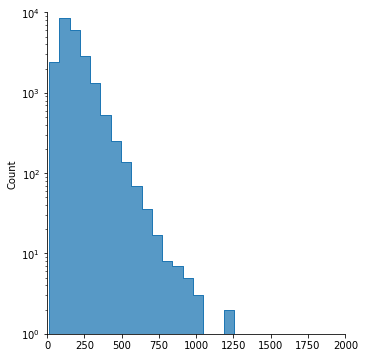

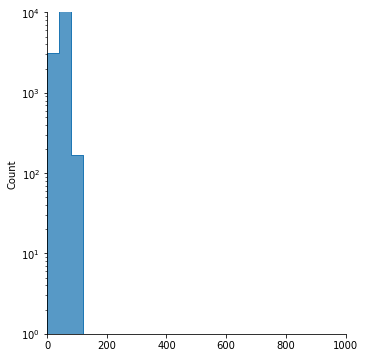

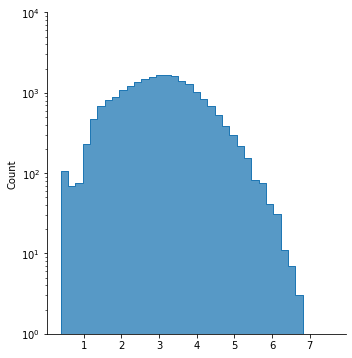

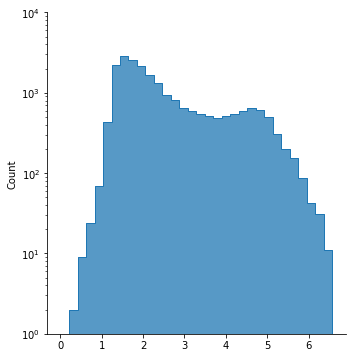

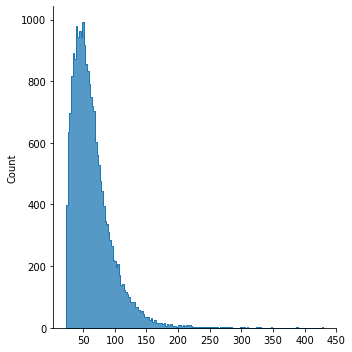

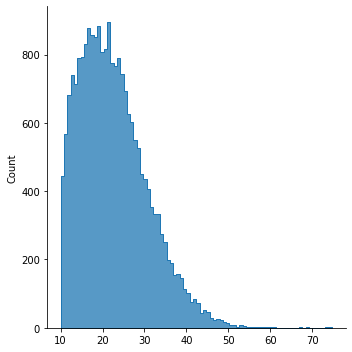

In [20]:
sns.displot(ttbar_mbb,bins=int((30/2000) * max(ttbar_mbb)),log_scale=[False,True],element='step')
plt.xlim(0,2000)
plt.ylim(1,10**4)
plt.plot()
sns.displot(ttbar_mll,bins=int((30/1000) * max(ttbar_mll)),log_scale=[False,True],element='step')
plt.xlim(0,1000)
plt.ylim(1,10**4)
plt.plot()
sns.displot(ttbar_rbb,bins=int((30/6) * max(ttbar_rbb)),log_scale=[False,True],element='step')
#plt.xlim(0,6)
plt.ylim(1,10**4)
plt.plot()
sns.displot(ttbar_rll,bins=int((30/6) * max(ttbar_rll)),log_scale=[False,True],element='step')
#plt.xlim(0,6)
plt.ylim(1,10**4)
plt.plot()
sns.displot(ttbar_ptj,element='step')
sns.displot(ttbar_ptl,element='step')

### llbj Process

In [13]:
p2 = get_plots(procname = 'llbj',file_location = '../../datasets/partonCuts_100k/')
p2.get_data()

INFO : Started Getting Data From File
INFO : Done Getting Data from File


In [14]:
llbj_mbb = p2.get_mbb()
llbj_mll = p2.get_mll()

[]

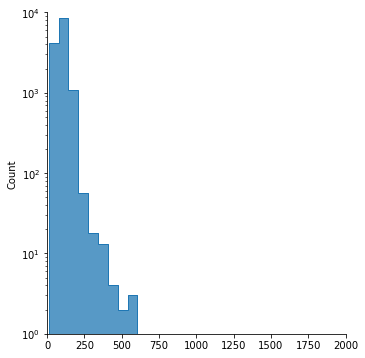

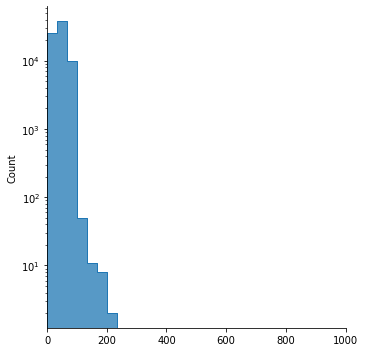

In [15]:
sns.displot(llbj_mbb,bins=int((30/2000) * max(llbj_mbb)),log_scale=[False,True],element='step')
plt.xlim(0,2000)
plt.ylim(1,10**4)
plt.plot()
sns.displot(llbj_mll,bins=int((30/1000) * max(llbj_mll)),log_scale=[False,True],element='step')
plt.xlim(0,1000)
#plt.ylim(1,10**4)
plt.plot()

### hh Process

In [3]:
p3 = get_plots(procname = 'hh',file_location = '../../datasets/partonCuts/')
p3.get_data()

INFO : Started Getting Data From File
INFO : Done Getting Data from File


In [4]:
hh_mbb = p3.get_mbb()
hh_mll = p3.get_mll()
hh_rbb = p3.get_rbb()

[]

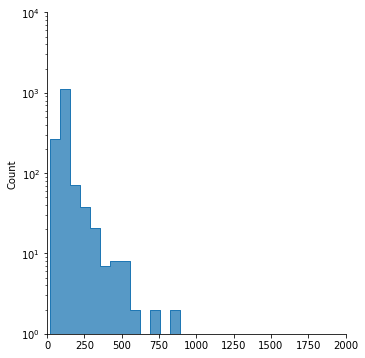

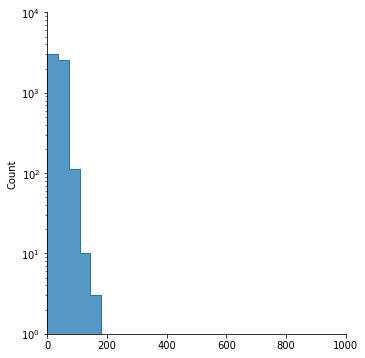

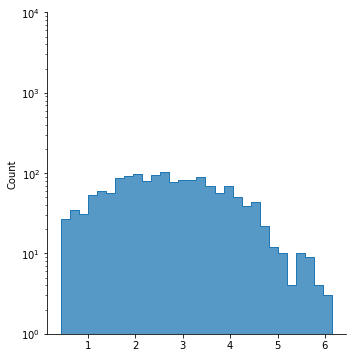

In [7]:
sns.displot(hh_mbb,bins=int((30/2000) * max(hh_mbb)),log_scale=[False,True],element='step')
plt.xlim(0,2000)
plt.ylim(1,10**4)
plt.plot()
sns.displot(hh_mll,bins=int((30/1000) * max(hh_mll)),log_scale=[False,True],element='step')
plt.xlim(0,1000)
plt.ylim(1,10**4)
plt.plot()
sns.displot(hh_rbb,bins=int((30/6) * max(hh_rbb)),log_scale=[False,True],element='step')
#plt.xlim(0,6)
plt.ylim(1,10**4)
plt.plot()